In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
import scipy.io as sio
from torchsummary import summary

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
import pdb

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

#H_org = sio.loadmat("H_1024x1024.mat")
length = 200
H_org = sio.loadmat("H_64x64_fs.mat")
interference = sio.loadmat("interference.mat")
int_extracted = interference['interference']
array = ['noisy_0dB', 'noisy_5dB', 'noisy_10dB', 'noisy_15dB', 'noisy_20dB']
save_array = ['vect_noise_64.mat','vect_noise_64_2.mat','vect_noise_64_3.mat','vect_noise_64_4.mat','vect_noise_64_5.mat']
vect_noise = np.zeros((64,64,len(save_array),length),dtype=complex)
for k in range(length): 
    H_extracted = H_org['noiseless']
    img_np_real = np.real(H_extracted[:,:,k])
    img_np_imag = np.imag(H_extracted[:,:,k])
    img_np = np.zeros((2,64,64))
    img_np[0,:,:] = img_np_real
    img_np[1,:,:] = img_np_imag
    img_clean_var = np_to_var(img_np).type(dtype)
    output_depth = img_np.shape[0] 
    print("Image size: ", img_np.shape)
    i = 0
    for noise_level in array:
        H_extracted = H_org[noise_level]
        img_noisy_np_real = np.real(H_extracted[:,:,0,k])#+ int_extracted[:,:,k])
        img_noisy_np_imag = np.imag(H_extracted[:,:,0,k])# + int_extracted[:,:,k])
        #img_noisy_np = np.zeros((2,1024,1024))
        img_noisy_np = np.zeros((2,64,64))
        img_noisy_np[0,:,:] = img_noisy_np_real
        img_noisy_np[1,:,:] = img_noisy_np_imag
        img_noisy_var = np_to_var(img_noisy_np).type(dtype)
        def denoise(img_noisy_var,k=128,numit = 200,rn = 0.0,find_best=True,upsample_first = True):
            num_channels = [k]*5
            net = decodernw(output_depth,num_channels_up=num_channels,upsample_first=upsample_first).type(dtype)
            summary(net, (64,2,2))
            pdb.set_trace()
            mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                                reg_noise_std=rn,
                                num_iter=numit,
                                img_noisy_var=img_noisy_var,
                                net=net,
                                img_clean_var=img_clean_var,
                                find_best=find_best
                                )
            out_img_np = net( ni.type(dtype) ).data.cpu().numpy()[0]
            return out_img_np, mse_t
        out_img_np, mse_t = denoise(img_noisy_var,k=64,numit = 1000,rn = 0.0)
        img_np_real = out_img_np[0,:,:]
        img_np_imag = out_img_np[1,:,:]
        vect_noise[:,:,i,k] = np.array(img_np_real+1j*img_np_imag,dtype=complex)
        pdb.set_trace()
        i = i+1
i = 0
for noise_level in array:       
    sio.savemat(save_array[i], {'vect_noise':vect_noise[:,:,i,:]})
    i = i+1

num GPUs 2
Image size:  (2, 64, 64)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1             [-1, 64, 2, 2]               0
            Conv2d-2             [-1, 64, 2, 2]           4,096
          Upsample-3             [-1, 64, 4, 4]               0
              ReLU-4             [-1, 64, 4, 4]               0
       BatchNorm2d-5             [-1, 64, 4, 4]             128
   ReflectionPad2d-6             [-1, 64, 4, 4]               0
            Conv2d-7             [-1, 64, 4, 4]           4,096
          Upsample-8             [-1, 64, 8, 8]               0
              ReLU-9             [-1, 64, 8, 8]               0
      BatchNorm2d-10             [-1, 64, 8, 8]             128
  ReflectionPad2d-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]           4,096
         Upsample-13           [-1, 64, 16, 16]               0
   

In [2]:
out_img_np[0,:,:]

array([[ 0.21568452,  0.21565308,  0.21559022, ...,  0.18358149,
         0.18351859,  0.18348712],
       [ 0.21382837,  0.21379824,  0.21373805, ...,  0.1821015 ,
         0.18203911,  0.1820079 ],
       [ 0.21011598,  0.21008858,  0.2100338 , ...,  0.17914157,
         0.17908011,  0.17904942],
       ...,
       [-0.356357  , -0.35631692, -0.35623682, ..., -0.54123855,
        -0.54197526, -0.5423436 ],
       [-0.3566841 , -0.35664394, -0.3565636 , ..., -0.5319226 ,
        -0.5326644 , -0.5330354 ],
       [-0.35684764, -0.3568074 , -0.35672697, ..., -0.5272646 ,
        -0.52800906, -0.5283813 ]], dtype=float32)

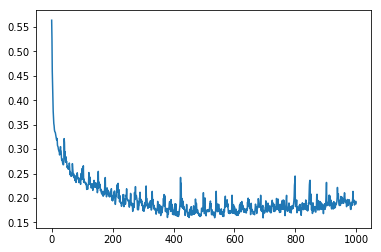

In [2]:
plt.plot(range(1000),mse_t)